# Kickstarter Projects
# Day 2 (Rev-1) Homework for a Machine Learning Course
Author：Hiroki Miyamoto

# Links to my homeworks
- Kaggle
    - Day1
        - Objective of Day 1 : Build a supervised machine learning model based on the lecture on Day 1. Don't care about the accuracy for now.
        - https://www.kaggle.com/hmiyamoto/day-1-homework-for-a-machine-learning-course/
    - Day2
        - Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.
        - https://www.kaggle.com/hmiyamoto/day-2-homework-for-a-machine-learning-course/
    - Day2 Appendix-1
        - Check the contribution of explanatory variables for prediction by investigating the weight
        - https://www.kaggle.com/hmiyamoto/day-2-homework-appendix-1
    - Day2 Appendix-2
        - Check the contribution of explanatory variables for prediction by investigating the weight again
            - "backers" and "usd_pledged_real" are removed from explanatory variables for success prediction because these variables are results of funding.
        - https://www.kaggle.com/hmiyamoto/day-2-homework-appendix-2
- GitHub
    - https://github.com/hmiyamoto1/skillupai_ml

## Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.

### "backers" and "usd_pledged_real" are removed from explanatory variables for success prediction because these variables are results of funding, as examined in the notebook Day 2 Appendix-2. 

### 2-variables 'category_dummy' and 'usd_goal_real_log10' are applied as explanatory variables because these variables are highly contributed to predict, as examined in the notebook Day 2 Appendix-2. 

### Table of Contents (Day 2)
1. Devide dataframe into train data(train & validation) and test data(final check)
1. Parameter study for Logistic Regression (L1)
1. Parameter study for Logistic Regression (L2)
1. Parameter study for SVM (Linear)
1. Parameter study for SVM (RBF)

# Summary

SVM was not so as good accuracy as logistic regression in this case.  As can be seen 2D graphs in this notebook, SVM couldn't create a distinct border surface because labels of the objective variable data are overlapped on a map created by selected explanatory variables.

| Model | Final Test Accuracy   |
|------|------|
|   Logistic Regression (L1)  | 68.929% |
|   Logistic Regression (L2)  | 68.932% |
|   SVM (Linear)  | 61.953% |
|   SVM (RBF)  | 60.256% |

- Objective variable
    - state_dummy (successful = 1, other = 0)
- Explanatory variables
    - usd_goal_real_log10
        - Second highly contributed variable to predict
    - category_dummy
        - is created by aggregating success rate of each category in training phase
        - First highly contributed variable to predict
        


# 0. Preparation

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ( 'x', '.', 'o', 's', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
                       
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    edgecolor=None,
                    marker=markers[idx], 
                    label=cl)

# 1. Devide dataframe into train data(trian & validation) and test data(final check)
- DataFrame
    - df_TRAIN : 80%
        - This will be further devided into train and validation data in holdout or cross-validation training phase.
            - train : 80%
            - valid : 20%
    - df_TEST : 20%
        - This is blind data for final test.

## Acquire data

In [3]:
df_kick = pd.read_csv("../input/ks-projects-201801.csv")

## Preview the data

In [4]:
display(df_kick.head())

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15      US        100.0   
2  2013-01-12 00:20:50    220.0    failed        3      US        220.0   
3  2012-03-17 03:24:11      1.0    failed        1      US          1.0   
4  2015-07-04 08:35:03   1283.0  canceled       14      US       1283.0   

   usd_pledged_real  usd_goal_real  
0               0.0        1533.95  
1            2421.0       30000.00  
2             220.0       45000.00  
3               1.0        5000.00  
4            1283.0       19500.00

## Create dataframe with selected features

In [5]:
df_kick['state_dummy'] = df_kick['state']
df_kick['state_dummy'].loc[df_kick['state_dummy'] != 'successful'] = 0
df_kick['state_dummy'].loc[df_kick['state_dummy'] == 'successful'] = 1

# display(df_kick.head())

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# epsilon = 1e-8
epsilon = 1

df_kick['usd_goal_real_log10'] = np.log10(df_kick['usd_goal_real'] + epsilon)

display(df_kick.head())

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15      US        100.0   
2  2013-01-12 00:20:50    220.0    failed        3      US        220.0   
3  2012-03-17 03:24:11      1.0    failed        1      US          1.0   
4  2015-07-04 08:35:03   1283.0  canceled       14      US       1283.0   

   usd_pledged_real  usd_goal_real  state_dummy  usd_goal_real_log10  
0               0.0        1533.95            0             3.186094  
1            2421.0       30000.00            0             4.477136  
2             220.0       45000.00            0             4.653222  
3               1.0        5000.00            0             3.699057  
4            1283.0       19500.00            0             4.290057

In [7]:
df_ALL = df_kick.loc[:, ['state_dummy', 'usd_goal_real_log10', 'category']]
df_ALL.head()

state_dummy  usd_goal_real_log10        category
0            0             3.186094          Poetry
1            0             4.477136  Narrative Film
2            0             4.653222  Narrative Film
3            0             3.699057           Music
4            0             4.290057    Film & Video

In [8]:
df_TRAIN, df_TEST = train_test_split(df_ALL, test_size=0.2, random_state=1234)
df_TRAIN.head()
display(df_TRAIN.describe())
display(df_TEST.describe())

state_dummy  usd_goal_real_log10
count  302928.000000        302928.000000
mean        0.354229             3.750413
std         0.478280             0.734916
min         0.000000             0.004321
25%         0.000000             3.301247
50%         0.000000             3.739286
75%         1.000000             4.188782
max         1.000000             8.221053

state_dummy  usd_goal_real_log10
count  75733.000000         75733.000000
mean       0.351894             3.752895
std        0.477564             0.733179
min        0.000000             0.173186
25%        0.000000             3.301247
50%        0.000000             3.740442
75%        1.000000             4.201308
max        1.000000             8.000000

# 2. Parameter study for Logistic Regression (L1)
- Model
    - Variables
        - Objective variable
            - state_dummy (successful = 1, other = 0)
        - Explanatory variables
            - usd_goal_real_log10
                - Second highly contributed variable to predict
            - category_dummy
                - will be created by aggregating success rate of each category in training phase
                - First highly contributed variable to predict
    - Cross validation (Train:80%/Valid:20% - 5 times) is applied.
    - **L1 regularization is applied here.**
- Cross Validation Result
    - Best parameter
        - **alpha = 1e-3  (1e-8 <= alpha <= 1e-1)**
        - Actually, alpha = 1e-2 was best prediction score. However, alpha = 1e-3 would be more stable.
    - Best score
        - **Cross Validation Log-likelihood = -10.886**
        - **Cross Validation Accuracy = 68.483%**
- Final Test Result (Applied best parameter)
    - Test score
        - **Test Log-likelihood = -10.732**
        - **Test Accuracy = 68.929%**

## Cross-Validation

penalty = l1
alpha = 1e-08

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


w0 = -5.775, w1 = 0.000, w2 = -1.079
Log-likelihood = -12.297
Accuracy = 64.396%

Fold 2
w0 = -5.232, w1 = 0.000, w2 = -1.168
Log-likelihood = -12.253
Accuracy = 64.523%

Fold 3
w0 = -6.282, w1 = 0.705, w2 = 0.000
Log-likelihood = -12.194
Accuracy = 64.695%

Fold 4
w0 = -3.959, w1 = -1.235, w2 = 0.000
Log-likelihood = -12.209
Accuracy = 64.651%

Fold 5
w0 = -3.928, w1 = -0.936, w2 = 1.989
Log-likelihood = -11.384
Accuracy = 67.041%



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


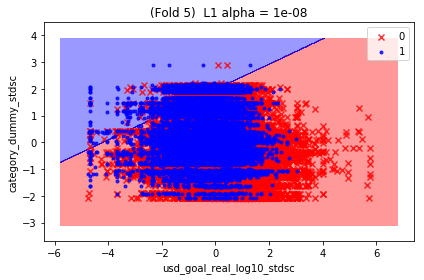

Cross Validation Log-likelihood = -12.067
Cross Validation Accuracy = 65.061%
penalty = l1
alpha = 1e-07

Fold 1
w0 = -1.055, w1 = -0.389, w2 = 0.000
Log-likelihood = -12.280
Accuracy = 64.446%

Fold 2
w0 = -1.343, w1 = -0.083, w2 = 0.000
Log-likelihood = -12.253
Accuracy = 64.523%

Fold 3
w0 = -1.328, w1 = 0.000, w2 = 0.197
Log-likelihood = -12.194
Accuracy = 64.695%

Fold 4
w0 = -1.138, w1 = -0.732, w2 = 0.385
Log-likelihood = -11.485
Accuracy = 66.748%

Fold 5
w0 = -0.953, w1 = -0.612, w2 = 0.350
Log-likelihood = -11.384
Accuracy = 67.041%



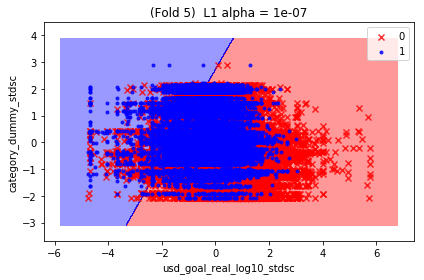

Cross Validation Log-likelihood = -11.919
Cross Validation Accuracy = 65.490%
penalty = l1
alpha = 1e-06

Fold 1
w0 = -0.831, w1 = -0.478, w2 = 0.600
Log-likelihood = -10.987
Accuracy = 68.189%

Fold 2
w0 = -0.876, w1 = -0.330, w2 = 0.519
Log-likelihood = -11.094
Accuracy = 67.879%

Fold 3
w0 = -0.836, w1 = -0.166, w2 = 0.659
Log-likelihood = -10.935
Accuracy = 68.339%

Fold 4
w0 = -0.855, w1 = -0.414, w2 = 0.402
Log-likelihood = -11.283
Accuracy = 67.333%

Fold 5
w0 = -0.863, w1 = -0.388, w2 = 0.403
Log-likelihood = -11.314
Accuracy = 67.243%



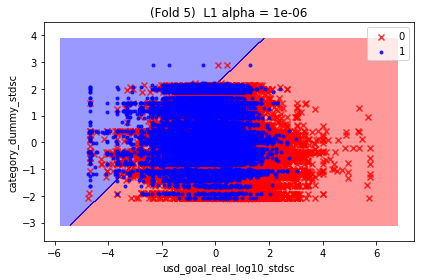

Cross Validation Log-likelihood = -11.123
Cross Validation Accuracy = 67.797%
penalty = l1
alpha = 1e-05

Fold 1
w0 = -0.744, w1 = -0.400, w2 = 0.657
Log-likelihood = -10.983
Accuracy = 68.201%

Fold 2
w0 = -0.713, w1 = -0.347, w2 = 0.648
Log-likelihood = -10.997
Accuracy = 68.161%

Fold 3
w0 = -0.776, w1 = -0.323, w2 = 0.634
Log-likelihood = -10.873
Accuracy = 68.521%

Fold 4
w0 = -0.698, w1 = -0.411, w2 = 0.561
Log-likelihood = -10.849
Accuracy = 68.588%

Fold 5
w0 = -0.674, w1 = -0.372, w2 = 0.576
Log-likelihood = -10.845
Accuracy = 68.599%



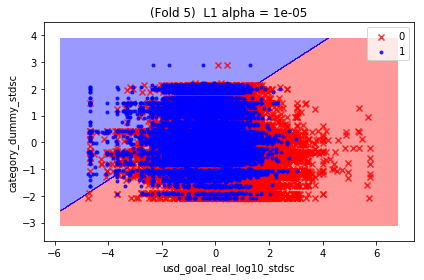

Cross Validation Log-likelihood = -10.909
Cross Validation Accuracy = 68.414%
penalty = l1
alpha = 0.0001

Fold 1
w0 = -0.690, w1 = -0.431, w2 = 0.612
Log-likelihood = -10.974
Accuracy = 68.229%

Fold 2
w0 = -0.687, w1 = -0.423, w2 = 0.615
Log-likelihood = -10.926
Accuracy = 68.367%

Fold 3
w0 = -0.698, w1 = -0.424, w2 = 0.599
Log-likelihood = -10.844
Accuracy = 68.605%

Fold 4
w0 = -0.680, w1 = -0.433, w2 = 0.590
Log-likelihood = -10.868
Accuracy = 68.533%

Fold 5
w0 = -0.687, w1 = -0.415, w2 = 0.605
Log-likelihood = -10.849
Accuracy = 68.590%



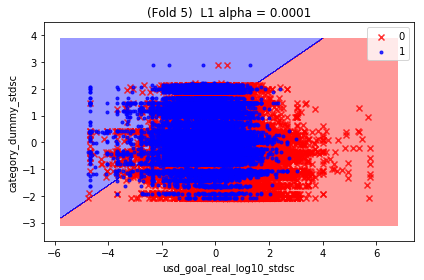

Cross Validation Log-likelihood = -10.892
Cross Validation Accuracy = 68.465%
penalty = l1
alpha = 0.001

Fold 1
w0 = -0.685, w1 = -0.434, w2 = 0.601
Log-likelihood = -10.967
Accuracy = 68.247%

Fold 2
w0 = -0.683, w1 = -0.432, w2 = 0.602
Log-likelihood = -10.933
Accuracy = 68.346%

Fold 3
w0 = -0.681, w1 = -0.434, w2 = 0.596
Log-likelihood = -10.835
Accuracy = 68.630%

Fold 4
w0 = -0.681, w1 = -0.431, w2 = 0.600
Log-likelihood = -10.847
Accuracy = 68.595%

Fold 5
w0 = -0.680, w1 = -0.425, w2 = 0.599
Log-likelihood = -10.845
Accuracy = 68.599%



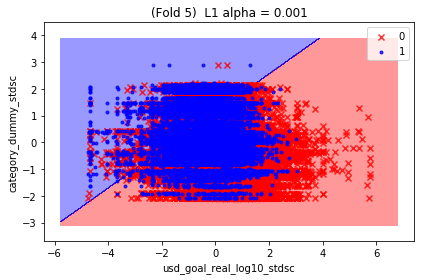

Cross Validation Log-likelihood = -10.886
Cross Validation Accuracy = 68.483%
penalty = l1
alpha = 0.01

Fold 1
w0 = -0.672, w1 = -0.387, w2 = 0.556
Log-likelihood = -10.962
Accuracy = 68.263%

Fold 2
w0 = -0.670, w1 = -0.384, w2 = 0.557
Log-likelihood = -10.925
Accuracy = 68.369%

Fold 3
w0 = -0.668, w1 = -0.388, w2 = 0.552
Log-likelihood = -10.840
Accuracy = 68.617%

Fold 4
w0 = -0.669, w1 = -0.385, w2 = 0.556
Log-likelihood = -10.858
Accuracy = 68.563%

Fold 5
w0 = -0.668, w1 = -0.382, w2 = 0.554
Log-likelihood = -10.834
Accuracy = 68.632%



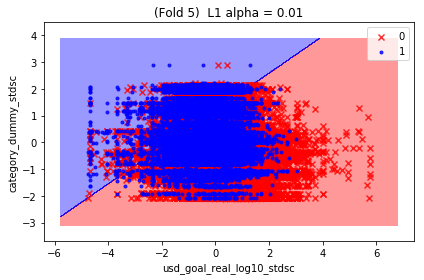

Cross Validation Log-likelihood = -10.884
Cross Validation Accuracy = 68.489%
penalty = l1
alpha = 0.1

Fold 1
w0 = -0.607, w1 = 0.000, w2 = 0.178
Log-likelihood = -12.297
Accuracy = 64.396%

Fold 2
w0 = -0.606, w1 = 0.000, w2 = 0.178
Log-likelihood = -12.253
Accuracy = 64.523%

Fold 3
w0 = -0.604, w1 = 0.000, w2 = 0.175
Log-likelihood = -12.194
Accuracy = 64.695%

Fold 4
w0 = -0.605, w1 = 0.000, w2 = 0.177
Log-likelihood = -12.226
Accuracy = 64.603%

Fold 5
w0 = -0.604, w1 = 0.000, w2 = 0.176
Log-likelihood = -12.203
Accuracy = 64.668%



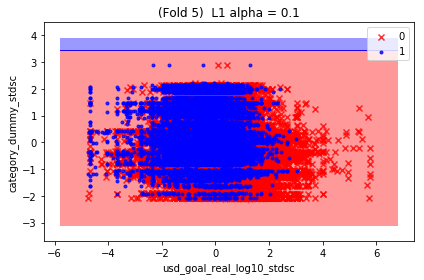

Cross Validation Log-likelihood = -12.235
Cross Validation Accuracy = 64.577%


In [11]:
penalty = 'l1'

alphas_multiply = np.array(range(-8,0))
alphas = 10.0 ** alphas_multiply

L1_accuracy = []
L1_log_likelihood = []
L1_weight_abs_max = []
L1_weight_abs_min = []


for alpha in alphas:
    
    print('='*100)
    print('penalty =', penalty)
    print('alpha =', alpha)
    print()

    y = df_TRAIN["state_dummy"].values
    X = df_TRAIN[["usd_goal_real_log10", "category"]].values

    n_split = 5 # Number of group

    cross_valid_log_likelihood = 0
    cross_valid_accuracy = 0
    split_num = 1

    # Cross Validation
    for train_idx, valid_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] # Train data
        X_valid, y_valid = X[valid_idx], y[valid_idx] # Validation data

        df_X_train = pd.DataFrame(X_train,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_valid = pd.DataFrame(X_valid,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_valid = pd.DataFrame(y_valid,
                                 columns=["state_dummy"])




        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_valid['category_dummy'] = df_X_valid['category'].replace(category_success_rate)


        print("Fold %s"%split_num)

        X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
        X_valid = df_X_valid[["usd_goal_real_log10", "category_dummy"]].values
        
        # Normaliztion
        stdsc = StandardScaler()
        X_train = stdsc.fit_transform(X_train)
        X_valid = stdsc.transform(X_valid)

        clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
        clf.fit(X_train, y_train)

        # Weight
        w0 = clf.intercept_[0]
        w1 = clf.coef_[0, 0]
        w2 = clf.coef_[0, 1]
        print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))


        # Predict labels
        y_est_valid = clf.predict(X_valid)

        # Log-likelihood
        log_likelihood = - log_loss(y_valid, y_est_valid)    
        cross_valid_log_likelihood += log_likelihood    
        print('Log-likelihood = {:.3f}'.format(log_likelihood))

        # Accuracy
        accuracy = accuracy_score(y_valid, y_est_valid)
        cross_valid_accuracy += accuracy   
        print('Accuracy = {:.3f}%'.format(100 * accuracy))
        print()
        
        if split_num == n_split:
            plot_decision_regions(X_valid, y_valid, classifier=clf)
            plt.title('(Fold %s)  L1 alpha = %s' %(split_num,alpha))
            plt.xlabel('usd_goal_real_log10_stdsc')
            plt.ylabel('category_dummy_stdsc')
            plt.axes().set_aspect('equal', 'datalim')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()

        split_num += 1

    # Generalization performance
    final_log_likelihood = cross_valid_log_likelihood / n_split
    print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
    final_accuracy = cross_valid_accuracy / n_split
    print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    
    L1_accuracy.append(final_accuracy)
    L1_log_likelihood.append(final_log_likelihood)
    L1_weight_abs_max.append(np.max(np.abs(clf.coef_)))
    L1_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

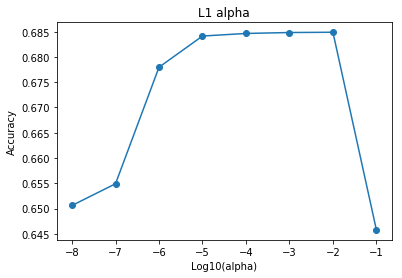

In [12]:
plt.plot(alphas_multiply, L1_accuracy, marker='o')
plt.title("L1 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Accuracy")
plt.show()

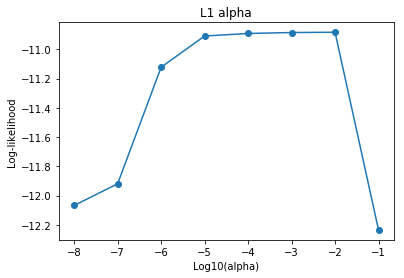

In [13]:
plt.plot(alphas_multiply, L1_log_likelihood, marker='o')
plt.title("L1 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Log-likelihood")
plt.show()

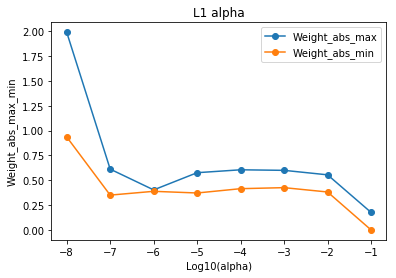

In [14]:
plt.plot(alphas_multiply, L1_weight_abs_max, marker='o', label='Weight_abs_max')
plt.plot(alphas_multiply, L1_weight_abs_min, marker='o', label='Weight_abs_min')
plt.title("L1 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Weight_abs_max_min")
plt.legend()
plt.show()

## Final Test

penalty = l1
alpha = 0.001



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w0 = -0.682, w1 = -0.430, w2 = 0.601
Test Log-likelihood = -10.732
Test Accuracy = 68.929%



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


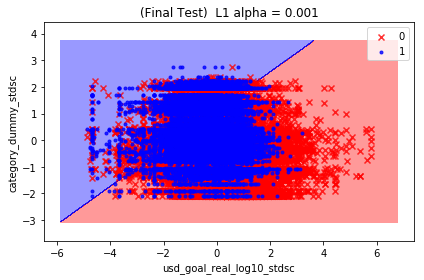

In [15]:
penalty = 'l1'

# Best Parameter
alpha = 1e-3


print('penalty =', penalty)
print('alpha =', alpha)
print()

# TRAIN data
df_y_train = df_TRAIN[["state_dummy"]]
df_X_train = df_TRAIN[["usd_goal_real_log10", "category"]]

# TEST data
df_y_test = df_TEST[["state_dummy"]]
df_X_test = df_TEST[["usd_goal_real_log10", "category"]]


# df_X_train = pd.DataFrame(X_train,
#                          columns=["usd_goal_real_log10", "category"])
# df_y_train = pd.DataFrame(y_train,
#                          columns=["state_dummy"])

# df_X_test = pd.DataFrame(X_test,
#                          columns=["usd_goal_real_log10", "category"])
# df_y_test = pd.DataFrame(y_test,
#                          columns=["state_dummy"])


# Create dummy variables for category using train data
# Replace category to category_success_rate
category_success_rate = {}
df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
df_category_all_count = df_X_train['category'].value_counts()
for category in df_category_all_count.keys():
    category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)



X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
X_test = df_X_test[["usd_goal_real_log10", "category_dummy"]].values

y_train = df_y_train[["state_dummy"]].values
y_test = df_y_test[["state_dummy"]].values

# Normaliztion
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)

# Weight
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))


# Predict labels
y_est_test = clf.predict(X_test)

# Log-likelihood
log_likelihood = - log_loss(y_test, y_est_test)       
print('Test Log-likelihood = {:.3f}'.format(log_likelihood))

# Accuracy
accuracy = accuracy_score(y_test, y_est_test)  
print('Test Accuracy = {:.3f}%'.format(100 * accuracy))
print()

plot_decision_regions(X_test, y_test.flatten(), classifier=clf)
plt.title('(Final Test)  L1 alpha = %s' %alpha)
plt.xlabel('usd_goal_real_log10_stdsc')
plt.ylabel('category_dummy_stdsc')
plt.axes().set_aspect('equal', 'datalim')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

    

# 3. Parameter study for Logistic Regression (L2)
- Model
    - Variables
        - Objective variable
            - state_dummy (successful = 1, other = 0)
        - Explanatory variables
            - usd_goal_real_log10
                - Second highly contributed variable to predict
            - category_dummy
                - will be created by aggregating success rate of each category in training phase
                - First highly contributed variable to predict
    - Cross validation (Train:80%/Valid:20% - 5 times) is applied.
    - **L2 regularization is applied here.**
- Cross Validation Result
    - Best parameter
        - **alpha = 1e-3  (1e-8 <= alpha <= 1e-1)**
    - Best score
        - **Cross Validation Log-likelihood = -10.885**
        - **Cross Validation Accuracy = 68.484%**
- Final Test Result (Applied best parameter)
    - Test score
        - **Test Log-likelihood = -10.731**
        - **Test Accuracy = 68.932%**

## Cross-Validation

penalty = l2
alpha = 1e-08

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


w0 = -5.476, w1 = -1.819, w2 = 2.718
Log-likelihood = -11.414
Accuracy = 66.953%

Fold 2
w0 = -5.187, w1 = -2.238, w2 = 2.829
Log-likelihood = -11.161
Accuracy = 67.686%

Fold 3
w0 = -10.168, w1 = -3.079, w2 = -1.086
Log-likelihood = -12.182
Accuracy = 64.729%

Fold 4
w0 = -5.562, w1 = -3.995, w2 = 2.048
Log-likelihood = -11.373
Accuracy = 67.073%

Fold 5
w0 = -3.999, w1 = -1.799, w2 = 4.174
Log-likelihood = -11.007
Accuracy = 68.131%



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


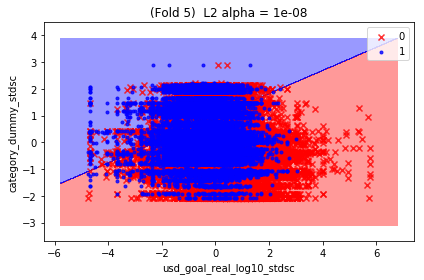

Cross Validation Log-likelihood = -11.427
Cross Validation Accuracy = 66.914%
penalty = l2
alpha = 1e-07

Fold 1
w0 = -1.086, w1 = -0.386, w2 = 0.162
Log-likelihood = -12.246
Accuracy = 64.543%

Fold 2
w0 = -1.432, w1 = -0.150, w2 = -0.001
Log-likelihood = -12.253
Accuracy = 64.523%

Fold 3
w0 = -1.317, w1 = 0.018, w2 = 0.168
Log-likelihood = -12.194
Accuracy = 64.695%

Fold 4
w0 = -1.259, w1 = -0.743, w2 = 0.487
Log-likelihood = -11.418
Accuracy = 66.941%

Fold 5
w0 = -1.153, w1 = -0.576, w2 = 0.570
Log-likelihood = -11.156
Accuracy = 67.700%



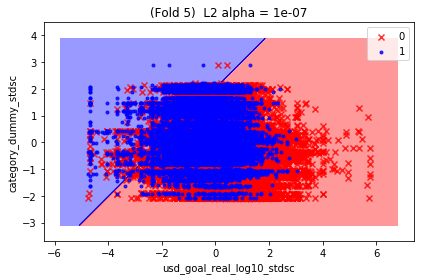

Cross Validation Log-likelihood = -11.854
Cross Validation Accuracy = 65.680%
penalty = l2
alpha = 1e-06

Fold 1
w0 = -0.831, w1 = -0.478, w2 = 0.600
Log-likelihood = -10.987
Accuracy = 68.189%

Fold 2
w0 = -0.876, w1 = -0.330, w2 = 0.519
Log-likelihood = -11.094
Accuracy = 67.879%

Fold 3
w0 = -0.836, w1 = -0.166, w2 = 0.659
Log-likelihood = -10.935
Accuracy = 68.339%

Fold 4
w0 = -0.855, w1 = -0.414, w2 = 0.402
Log-likelihood = -11.283
Accuracy = 67.333%

Fold 5
w0 = -0.863, w1 = -0.388, w2 = 0.403
Log-likelihood = -11.314
Accuracy = 67.243%



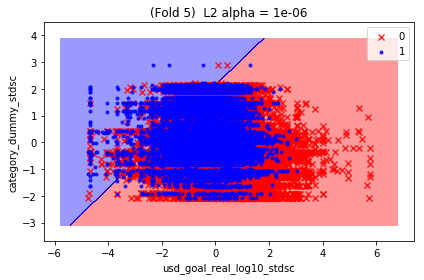

Cross Validation Log-likelihood = -11.123
Cross Validation Accuracy = 67.797%
penalty = l2
alpha = 1e-05

Fold 1
w0 = -0.744, w1 = -0.400, w2 = 0.657
Log-likelihood = -10.983
Accuracy = 68.201%

Fold 2
w0 = -0.713, w1 = -0.347, w2 = 0.648
Log-likelihood = -10.997
Accuracy = 68.161%

Fold 3
w0 = -0.776, w1 = -0.323, w2 = 0.634
Log-likelihood = -10.873
Accuracy = 68.521%

Fold 4
w0 = -0.698, w1 = -0.412, w2 = 0.561
Log-likelihood = -10.849
Accuracy = 68.588%

Fold 5
w0 = -0.674, w1 = -0.372, w2 = 0.576
Log-likelihood = -10.845
Accuracy = 68.599%



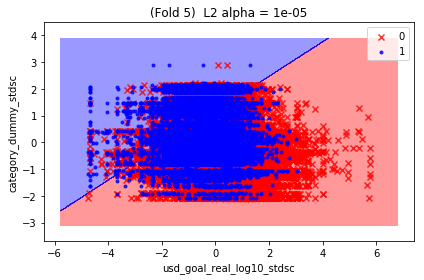

Cross Validation Log-likelihood = -10.909
Cross Validation Accuracy = 68.414%
penalty = l2
alpha = 0.0001

Fold 1
w0 = -0.690, w1 = -0.431, w2 = 0.612
Log-likelihood = -10.974
Accuracy = 68.227%

Fold 2
w0 = -0.687, w1 = -0.424, w2 = 0.615
Log-likelihood = -10.926
Accuracy = 68.367%

Fold 3
w0 = -0.698, w1 = -0.425, w2 = 0.599
Log-likelihood = -10.844
Accuracy = 68.605%

Fold 4
w0 = -0.680, w1 = -0.433, w2 = 0.591
Log-likelihood = -10.866
Accuracy = 68.540%

Fold 5
w0 = -0.688, w1 = -0.415, w2 = 0.605
Log-likelihood = -10.849
Accuracy = 68.590%



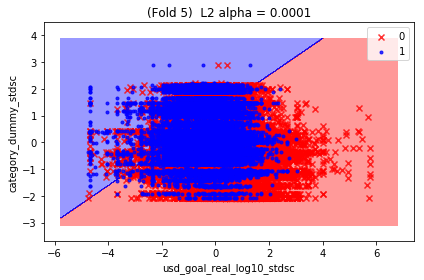

Cross Validation Log-likelihood = -10.892
Cross Validation Accuracy = 68.466%
penalty = l2
alpha = 0.001

Fold 1
w0 = -0.686, w1 = -0.437, w2 = 0.603
Log-likelihood = -10.964
Accuracy = 68.255%

Fold 2
w0 = -0.683, w1 = -0.435, w2 = 0.604
Log-likelihood = -10.930
Accuracy = 68.354%

Fold 3
w0 = -0.682, w1 = -0.438, w2 = 0.598
Log-likelihood = -10.835
Accuracy = 68.630%

Fold 4
w0 = -0.682, w1 = -0.434, w2 = 0.602
Log-likelihood = -10.851
Accuracy = 68.585%

Fold 5
w0 = -0.680, w1 = -0.428, w2 = 0.601
Log-likelihood = -10.847
Accuracy = 68.596%



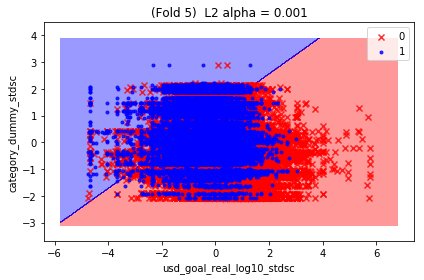

Cross Validation Log-likelihood = -10.885
Cross Validation Accuracy = 68.484%
penalty = l2
alpha = 0.01

Fold 1
w0 = -0.679, w1 = -0.418, w2 = 0.577
Log-likelihood = -10.988
Accuracy = 68.186%

Fold 2
w0 = -0.677, w1 = -0.415, w2 = 0.577
Log-likelihood = -10.920
Accuracy = 68.384%

Fold 3
w0 = -0.675, w1 = -0.419, w2 = 0.573
Log-likelihood = -10.842
Accuracy = 68.610%

Fold 4
w0 = -0.676, w1 = -0.416, w2 = 0.576
Log-likelihood = -10.867
Accuracy = 68.537%

Fold 5
w0 = -0.674, w1 = -0.413, w2 = 0.575
Log-likelihood = -10.854
Accuracy = 68.575%



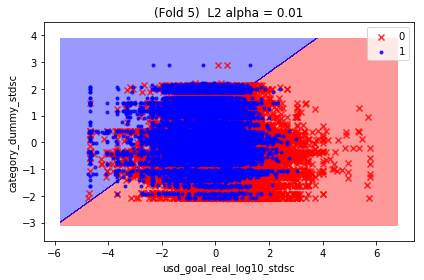

Cross Validation Log-likelihood = -10.894
Cross Validation Accuracy = 68.458%
penalty = l2
alpha = 0.1

Fold 1
w0 = -0.643, w1 = -0.297, w2 = 0.409
Log-likelihood = -11.048
Accuracy = 68.012%

Fold 2
w0 = -0.641, w1 = -0.295, w2 = 0.409
Log-likelihood = -11.041
Accuracy = 68.032%

Fold 3
w0 = -0.639, w1 = -0.298, w2 = 0.406
Log-likelihood = -10.932
Accuracy = 68.349%

Fold 4
w0 = -0.640, w1 = -0.295, w2 = 0.408
Log-likelihood = -10.953
Accuracy = 68.288%

Fold 5
w0 = -0.639, w1 = -0.293, w2 = 0.407
Log-likelihood = -10.900
Accuracy = 68.441%



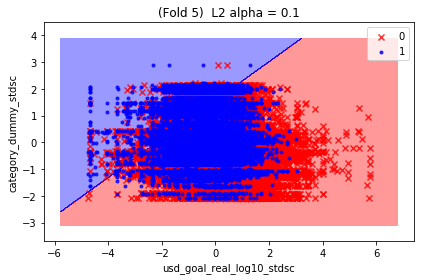

Cross Validation Log-likelihood = -10.975
Cross Validation Accuracy = 68.224%


In [16]:
penalty = 'l2'

alphas_multiply = np.array(range(-8,0))
alphas = 10.0 ** alphas_multiply

L2_accuracy = []
L2_log_likelihood = []
L2_weight_abs_max = []
L2_weight_abs_min = []


for alpha in alphas:
    
    print('='*100)
    print('penalty =', penalty)
    print('alpha =', alpha)
    print()

    y = df_TRAIN["state_dummy"].values
    X = df_TRAIN[["usd_goal_real_log10", "category"]].values

    n_split = 5 # Number of group

    cross_valid_log_likelihood = 0
    cross_valid_accuracy = 0
    split_num = 1

    # Cross Validation
    for train_idx, valid_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] # Train data
        X_valid, y_valid = X[valid_idx], y[valid_idx] # Validation data

        df_X_train = pd.DataFrame(X_train,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_valid = pd.DataFrame(X_valid,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_valid = pd.DataFrame(y_valid,
                                 columns=["state_dummy"])




        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_valid['category_dummy'] = df_X_valid['category'].replace(category_success_rate)


        print("Fold %s"%split_num)

        X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
        X_valid = df_X_valid[["usd_goal_real_log10", "category_dummy"]].values
        
        # Normaliztion
        stdsc = StandardScaler()
        X_train = stdsc.fit_transform(X_train)
        X_valid = stdsc.transform(X_valid)

        clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
        clf.fit(X_train, y_train)

        # Weight
        w0 = clf.intercept_[0]
        w1 = clf.coef_[0, 0]
        w2 = clf.coef_[0, 1]
        print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))


        # Predict labels
        y_est_valid = clf.predict(X_valid)

        # Log-likelihood
        log_likelihood = - log_loss(y_valid, y_est_valid)    
        cross_valid_log_likelihood += log_likelihood    
        print('Log-likelihood = {:.3f}'.format(log_likelihood))

        # Accuracy
        accuracy = accuracy_score(y_valid, y_est_valid)
        cross_valid_accuracy += accuracy   
        print('Accuracy = {:.3f}%'.format(100 * accuracy))
        print()
        
        if split_num == n_split:
            plot_decision_regions(X_valid, y_valid, classifier=clf)
            plt.title('(Fold %s)  L2 alpha = %s' %(split_num,alpha))
            plt.xlabel('usd_goal_real_log10_stdsc')
            plt.ylabel('category_dummy_stdsc')
            plt.axes().set_aspect('equal', 'datalim')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()

        split_num += 1

    # Generalization performance
    final_log_likelihood = cross_valid_log_likelihood / n_split
    print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
    final_accuracy = cross_valid_accuracy / n_split
    print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    
    L2_accuracy.append(final_accuracy)
    L2_log_likelihood.append(final_log_likelihood)
    L2_weight_abs_max.append(np.max(np.abs(clf.coef_)))
    L2_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

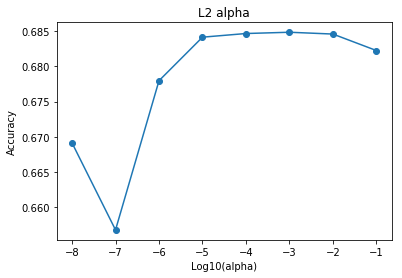

In [17]:
plt.plot(alphas_multiply, L2_accuracy, marker='o')
plt.title("L2 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Accuracy")
plt.show()

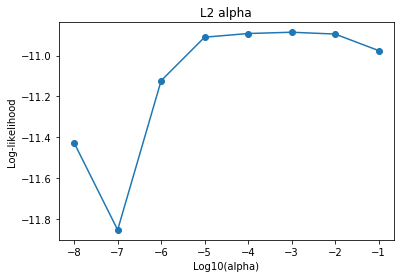

In [18]:
plt.plot(alphas_multiply, L2_log_likelihood, marker='o')
plt.title("L2 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Log-likelihood")
plt.show()

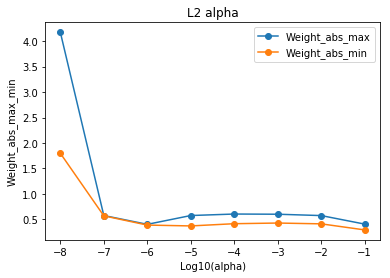

In [19]:
plt.plot(alphas_multiply, L2_weight_abs_max, marker='o', label='Weight_abs_max')
plt.plot(alphas_multiply, L2_weight_abs_min, marker='o', label='Weight_abs_min')
plt.title("L2 alpha")
plt.xlabel("Log10(alpha)")
plt.ylabel("Weight_abs_max_min")
plt.legend()
plt.show()

## Final Test

penalty = l2
alpha = 0.001



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


w0 = -0.682, w1 = -0.433, w2 = 0.603
Test Log-likelihood = -10.731
Test Accuracy = 68.932%



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


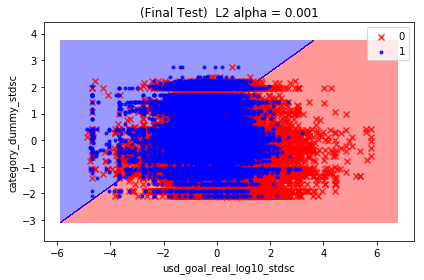

In [20]:
penalty = 'l2'

# Best Parameter
alpha = 1e-3


print('penalty =', penalty)
print('alpha =', alpha)
print()

# TRAIN data
df_y_train = df_TRAIN[["state_dummy"]]
df_X_train = df_TRAIN[["usd_goal_real_log10", "category"]]

# TEST data
df_y_test = df_TEST[["state_dummy"]]
df_X_test = df_TEST[["usd_goal_real_log10", "category"]]


# df_X_train = pd.DataFrame(X_train,
#                          columns=["usd_goal_real_log10", "category"])
# df_y_train = pd.DataFrame(y_train,
#                          columns=["state_dummy"])

# df_X_test = pd.DataFrame(X_test,
#                          columns=["usd_goal_real_log10", "category"])
# df_y_test = pd.DataFrame(y_test,
#                          columns=["state_dummy"])


# Create dummy variables for category using train data
# Replace category to category_success_rate
category_success_rate = {}
df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
df_category_all_count = df_X_train['category'].value_counts()
for category in df_category_all_count.keys():
    category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)



X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
X_test = df_X_test[["usd_goal_real_log10", "category_dummy"]].values

y_train = df_y_train[["state_dummy"]].values
y_test = df_y_test[["state_dummy"]].values

# Normaliztion
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)

# Weight
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))


# Predict labels
y_est_test = clf.predict(X_test)

# Log-likelihood
log_likelihood = - log_loss(y_test, y_est_test)       
print('Test Log-likelihood = {:.3f}'.format(log_likelihood))

# Accuracy
accuracy = accuracy_score(y_test, y_est_test)  
print('Test Accuracy = {:.3f}%'.format(100 * accuracy))
print()

plot_decision_regions(X_test, y_test.flatten(), classifier=clf)
plt.title('(Final Test)  L2 alpha = %s' %alpha)
plt.xlabel('usd_goal_real_log10_stdsc')
plt.ylabel('category_dummy_stdsc')
plt.axes().set_aspect('equal', 'datalim')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

    

# 4. Parameter study for SVM (Linear)
- Model
    - Variables
        - Objective variable
            - state_dummy (successful = 1, other = 0)
        - Explanatory variables
            - usd_goal_real_log10
                - Second highly contributed variable to predict
            - category_dummy
                - will be created by aggregating success rate of each category in training phase
                - First highly contributed variable to predict
    - **SVM (Linear) is applied here.**
    - **Holdout method is applied for SVM parameter study instead of cross validation to shorten the calculation time.**
- Cross Validation Result
    - Best parameter
        - **C = 1e-4  (1e-8 <= C <= 1e3)**
    - Best score
        - **Holdout Log-likelihood = -13.752**
        - **Holdout Accuracy = 60.184%**
- Final Test Result (Applied best parameter)
    - Test score
        - **Test Log-likelihood = -13.141**
        - **Test Accuracy = 61.953%**

## Holdout Method

kernel = linear
C = 1e-08



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


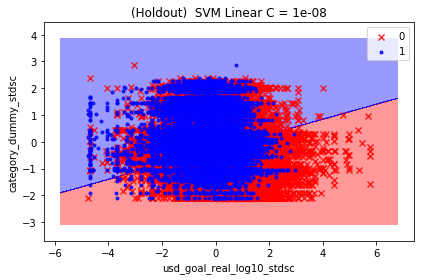

Holdout Log-likelihood = -13.752
Holdout Accuracy = 60.184%
kernel = linear
C = 1e-07



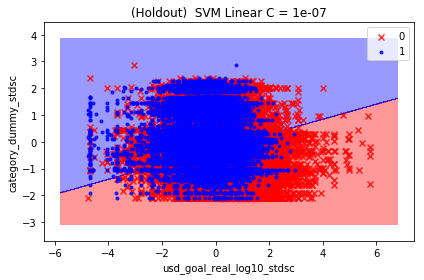

Holdout Log-likelihood = -13.752
Holdout Accuracy = 60.184%
kernel = linear
C = 1e-06



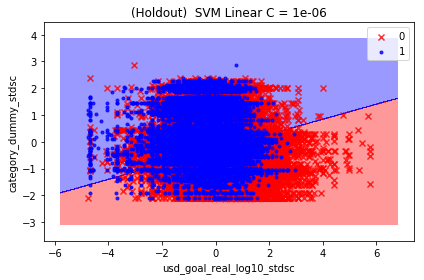

Holdout Log-likelihood = -13.752
Holdout Accuracy = 60.184%
kernel = linear
C = 1e-05



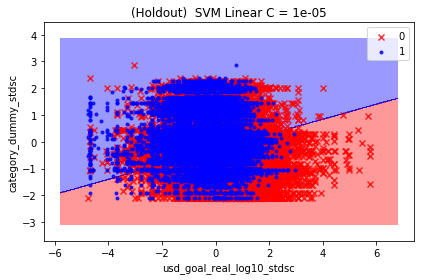

Holdout Log-likelihood = -13.752
Holdout Accuracy = 60.184%
kernel = linear
C = 0.0001



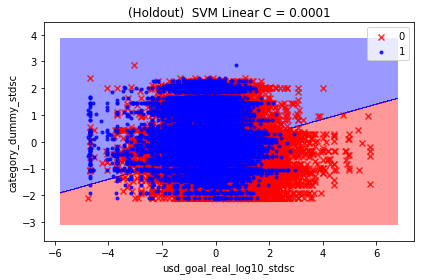

Holdout Log-likelihood = -13.752
Holdout Accuracy = 60.184%
kernel = linear
C = 0.001



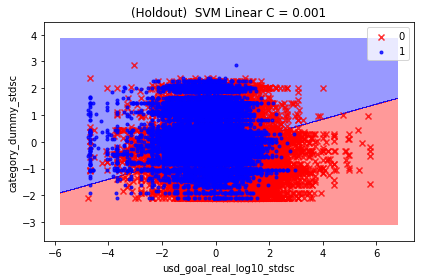

Holdout Log-likelihood = -13.752
Holdout Accuracy = 60.184%
kernel = linear
C = 0.01



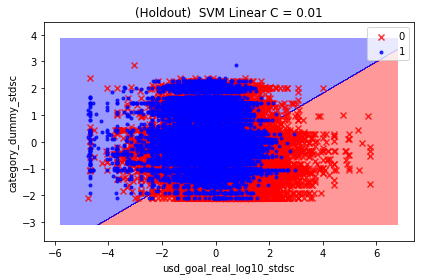

Holdout Log-likelihood = -14.632
Holdout Accuracy = 57.637%
kernel = linear
C = 0.1



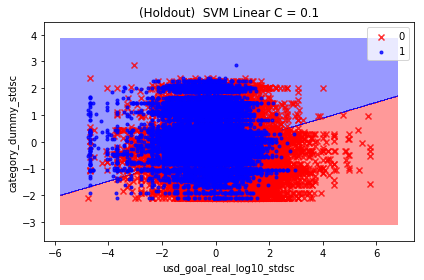

Holdout Log-likelihood = -13.8
Holdout Accuracy = 60.047%
kernel = linear
C = 1.0



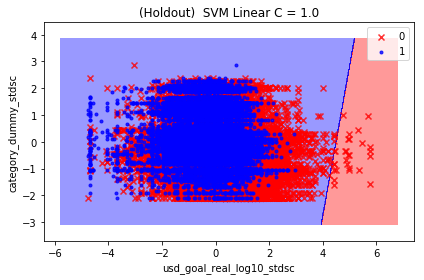

Holdout Log-likelihood = -22.303
Holdout Accuracy = 35.429%
kernel = linear
C = 10.0



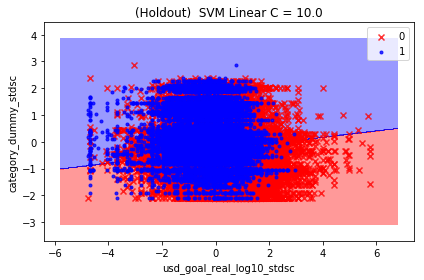

Holdout Log-likelihood = -14.411
Holdout Accuracy = 58.276%
kernel = linear
C = 100.0



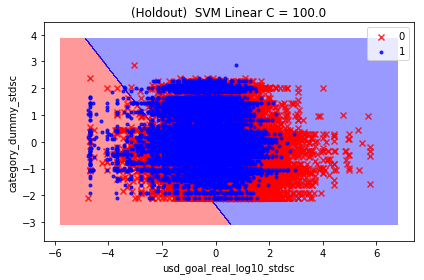

Holdout Log-likelihood = -21.791
Holdout Accuracy = 36.911%
kernel = linear
C = 1000.0



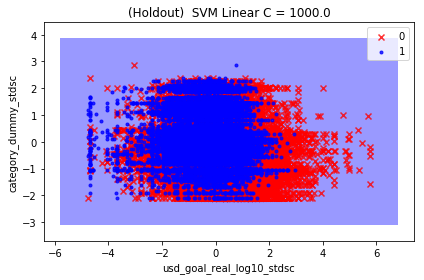

Holdout Log-likelihood = -22.318
Holdout Accuracy = 35.384%


In [21]:
kernel = 'linear'
# Cs = [0.001, 0.01, 0.1, 1, 10]
Cs = np.logspace(-8, 3, 12, base=10)

SVM_accuracy = []
SVM_log_likelihood = []
SVM_weight_abs_max = []
SVM_weight_abs_min = []


for C in Cs:
    
    print('='*100)
    print('kernel =', kernel)
    print('C =', C)
    print()
    
    y = df_TRAIN["state_dummy"].values
    X = df_TRAIN[["usd_goal_real_log10", "category"]].values

    # Holdout method
    test_size = 0.2        # 20%
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=1234) # Holdout


    df_X_train = pd.DataFrame(X_train,
                             columns=["usd_goal_real_log10", "category"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_valid = pd.DataFrame(X_valid,
                             columns=["usd_goal_real_log10", "category"])
    df_y_valid = pd.DataFrame(y_valid,
                             columns=["state_dummy"])


    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_valid['category_dummy'] = df_X_valid['category'].replace(category_success_rate)

    X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
    X_valid = df_X_valid[["usd_goal_real_log10", "category_dummy"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_valid = stdsc.transform(X_valid)

    clf = SVC(C=C,kernel=kernel, max_iter=2000, random_state=1234)
    clf.fit(X_train, y_train)

    # Predict labels
    y_est_valid = clf.predict(X_valid)

    # Log-likelihood
    holdout_log_likelihood = - log_loss(y_valid, y_est_valid)         

    # Accuracy
    holdout_accuracy = accuracy_score(y_valid, y_est_valid)
    
    plot_decision_regions(X_valid, y_valid, classifier=clf)
    plt.title('(Holdout)  SVM Linear C = %s' %C)
    plt.xlabel('usd_goal_real_log10_stdsc')
    plt.ylabel('category_dummy_stdsc')
    plt.axes().set_aspect('equal', 'datalim')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Generalization performance
    final_log_likelihood = holdout_log_likelihood
    print("Holdout Log-likelihood = %s"%round(final_log_likelihood, 3))
    final_accuracy = holdout_accuracy
    print('Holdout Accuracy = {:.3f}%'.format(100 * final_accuracy))
    
    SVM_accuracy.append(final_accuracy)
    SVM_log_likelihood.append(final_log_likelihood)
    SVM_weight_abs_max.append(np.max(np.abs(clf.coef_)))
    SVM_weight_abs_min.append(np.min(np.abs(clf.coef_)))
    

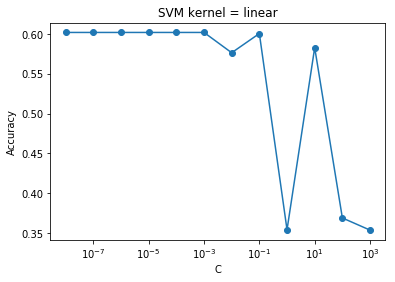

In [22]:
plt.plot(Cs, SVM_accuracy, marker='o')
plt.title("SVM kernel = linear")
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Accuracy")
plt.show()

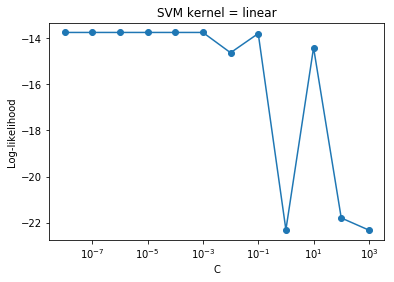

In [23]:
plt.plot(Cs, SVM_log_likelihood, marker='o')
plt.title("SVM kernel = linear")
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Log-likelihood")
plt.show()

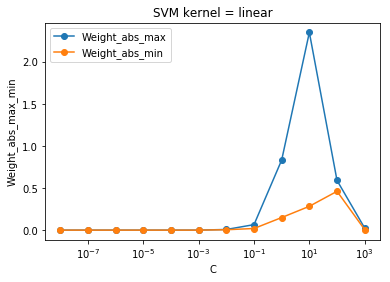

In [24]:
plt.plot(Cs, SVM_weight_abs_max, marker='o', label='Weight_abs_max')
plt.plot(Cs, SVM_weight_abs_min, marker='o', label='Weight_abs_min')
plt.title("SVM kernel = linear")
plt.xlabel("C")
plt.xscale('log')
plt.ylabel("Weight_abs_max_min")
plt.legend()
plt.show()

## Final Test

kernel = linear
C = 0.0001



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Test Log-likelihood = -13.141
Test Accuracy = 61.953%



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


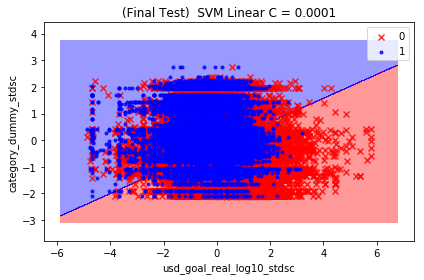

In [25]:
kernel = 'linear'

# Best Parameter
C = 1e-4


print('kernel =', kernel)
print('C =', C)
print()

# TRAIN data
df_y_train = df_TRAIN[["state_dummy"]]
df_X_train = df_TRAIN[["usd_goal_real_log10", "category"]]

# TEST data
df_y_test = df_TEST[["state_dummy"]]
df_X_test = df_TEST[["usd_goal_real_log10", "category"]]

# Create dummy variables for category using train data
# Replace category to category_success_rate
category_success_rate = {}
df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
df_category_all_count = df_X_train['category'].value_counts()
for category in df_category_all_count.keys():
    category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)



X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
X_test = df_X_test[["usd_goal_real_log10", "category_dummy"]].values

y_train = df_y_train[["state_dummy"]].values
y_test = df_y_test[["state_dummy"]].values

# print(X_test.shape)
# print(y_test.flatten().shape)

# print(X_valid.shape)
# print(y_valid.shape)

# Normaliztion
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

clf = SVC(C=C,kernel=kernel, max_iter=2000, random_state=1234)
clf.fit(X_train, y_train)

# Predict labels
y_est_test = clf.predict(X_test)

# Log-likelihood
log_likelihood = - log_loss(y_test, y_est_test)       
print('Test Log-likelihood = {:.3f}'.format(log_likelihood))

# Accuracy
accuracy = accuracy_score(y_test, y_est_test)  
print('Test Accuracy = {:.3f}%'.format(100 * accuracy))
print()

plot_decision_regions(X_test, y_test.flatten(), classifier=clf)
plt.title('(Final Test)  SVM Linear C = %s' %C)
plt.xlabel('usd_goal_real_log10_stdsc')
plt.ylabel('category_dummy_stdsc')
plt.axes().set_aspect('equal', 'datalim')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

    

# 5. Parameter study for SVM (RBF)
- Model
    - Variables
        - Objective variable
            - state_dummy (successful = 1, other = 0)
        - Explanatory variables
            - usd_goal_real_log10
                - Second highly contributed variable to predict
            - category_dummy
                - will be created by aggregating success rate of each category in training phase
                - First highly contributed variable to predict
    - **SVM (RBF) is applied here.**
    - **Holdout method is applied for SVM parameter study instead of cross validation to shorten the calculation time.**
- Cross Validation Result
    - Best parameter
        - **C = 1e2  (1e-4 <= C <= 1e2)**
        - **gamma = 1e-8  (1e-10 <= gamma <= 1e-4)**
    - Best score
        - **Holdout Log-likelihood = -10.894**
        - **Holdout Accuracy = 68.460%**
- Final Test Result (Applied best parameter)
    - Test score
        - **Test Log-likelihood = -13.727**
        - **Test Accuracy = 60.256%**

## Holdout Method

kernel = rbf
C = 0.0001
gamma = 1e-10



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


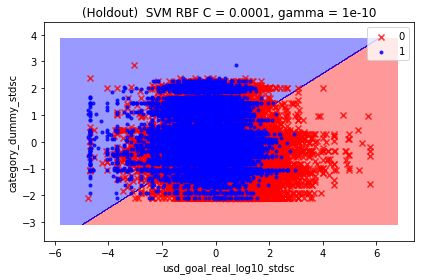

Holdout Log-likelihood = -12.231
Holdout Accuracy = 64.589%
kernel = rbf
C = 0.0001
gamma = 1e-09



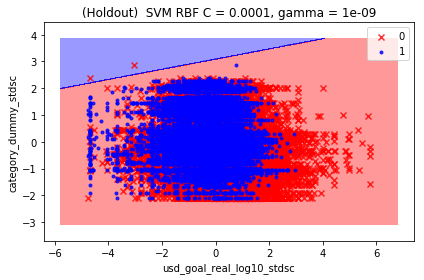

Holdout Log-likelihood = -12.222
Holdout Accuracy = 64.612%
kernel = rbf
C = 0.0001
gamma = 1e-08



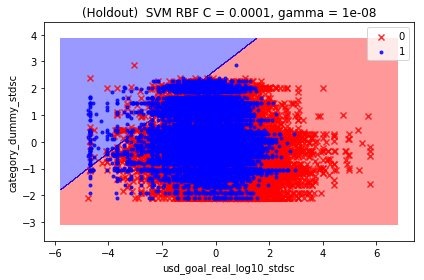

Holdout Log-likelihood = -11.911
Holdout Accuracy = 65.515%
kernel = rbf
C = 0.0001
gamma = 1e-07



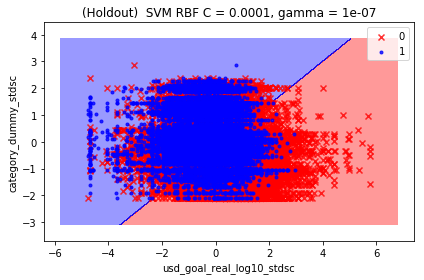

Holdout Log-likelihood = -13.211
Holdout Accuracy = 61.750%
kernel = rbf
C = 0.0001
gamma = 1e-06



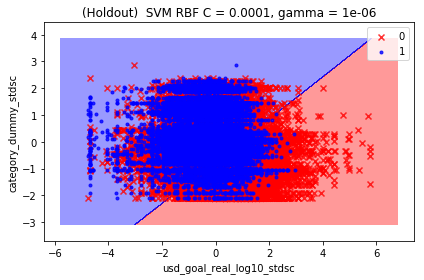

Holdout Log-likelihood = -15.36
Holdout Accuracy = 55.529%
kernel = rbf
C = 0.0001
gamma = 1e-05



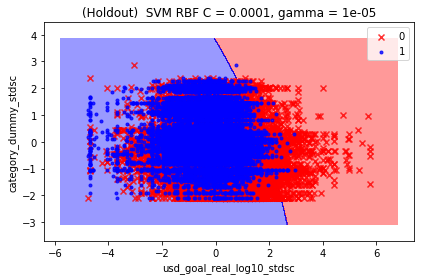

Holdout Log-likelihood = -21.492
Holdout Accuracy = 37.776%
kernel = rbf
C = 0.0001
gamma = 0.0001



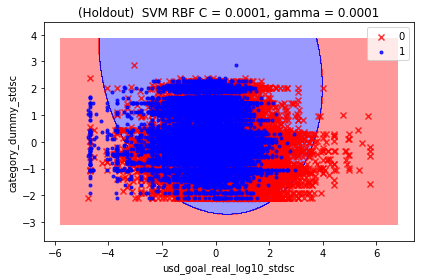

Holdout Log-likelihood = -22.234
Holdout Accuracy = 35.627%
kernel = rbf
C = 0.001
gamma = 1e-10



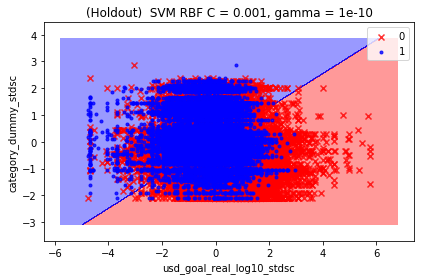

Holdout Log-likelihood = -12.231
Holdout Accuracy = 64.589%
kernel = rbf
C = 0.001
gamma = 1e-09



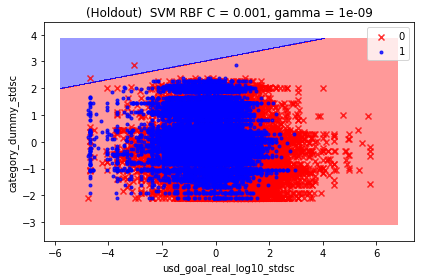

Holdout Log-likelihood = -12.222
Holdout Accuracy = 64.612%
kernel = rbf
C = 0.001
gamma = 1e-08



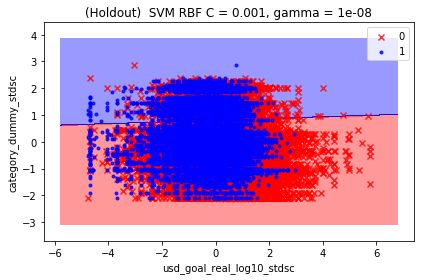

Holdout Log-likelihood = -11.374
Holdout Accuracy = 67.068%
kernel = rbf
C = 0.001
gamma = 1e-07



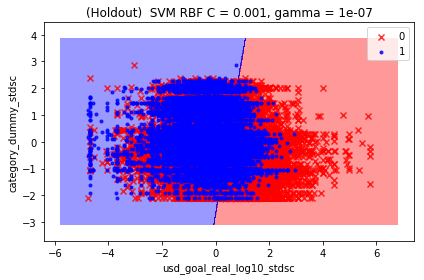

Holdout Log-likelihood = -15.816
Holdout Accuracy = 54.209%
kernel = rbf
C = 0.001
gamma = 1e-06



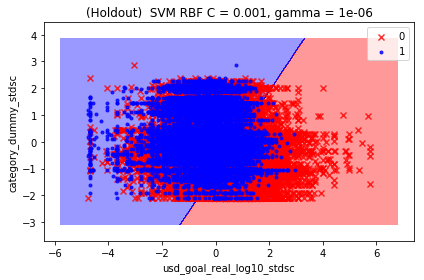

Holdout Log-likelihood = -15.943
Holdout Accuracy = 53.841%
kernel = rbf
C = 0.001
gamma = 1e-05



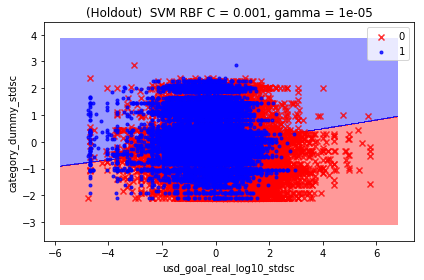

Holdout Log-likelihood = -13.188
Holdout Accuracy = 61.816%
kernel = rbf
C = 0.001
gamma = 0.0001



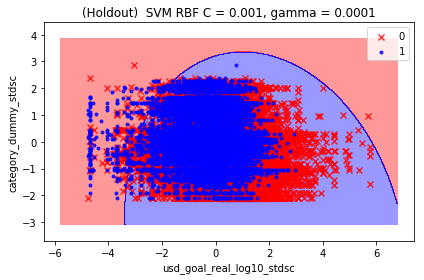

Holdout Log-likelihood = -22.385
Holdout Accuracy = 35.191%
kernel = rbf
C = 0.01
gamma = 1e-10



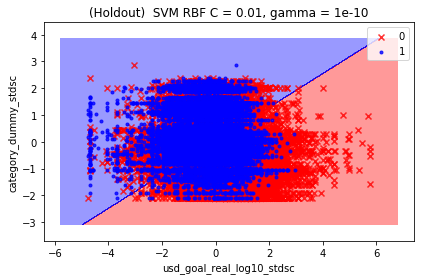

Holdout Log-likelihood = -12.231
Holdout Accuracy = 64.589%
kernel = rbf
C = 0.01
gamma = 1e-09



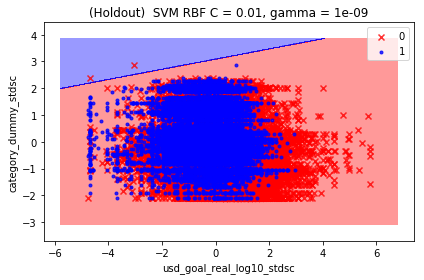

Holdout Log-likelihood = -12.222
Holdout Accuracy = 64.612%
kernel = rbf
C = 0.01
gamma = 1e-08



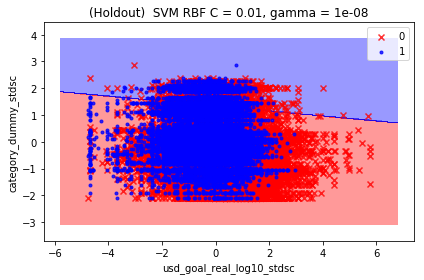

Holdout Log-likelihood = -11.586
Holdout Accuracy = 66.456%
kernel = rbf
C = 0.01
gamma = 1e-07



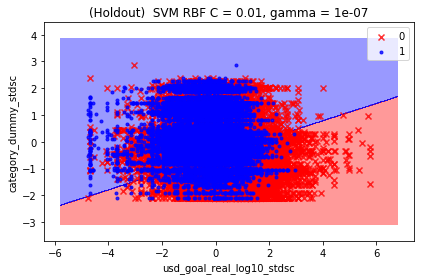

Holdout Log-likelihood = -14.923
Holdout Accuracy = 56.795%
kernel = rbf
C = 0.01
gamma = 1e-06



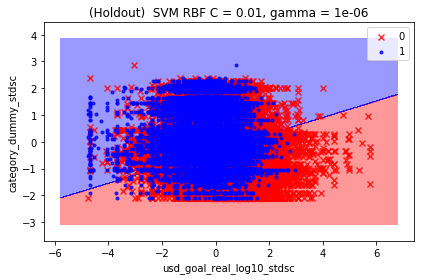

Holdout Log-likelihood = -13.886
Holdout Accuracy = 59.796%
kernel = rbf
C = 0.01
gamma = 1e-05



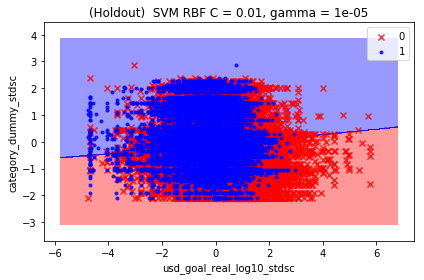

Holdout Log-likelihood = -13.37
Holdout Accuracy = 61.291%
kernel = rbf
C = 0.01
gamma = 0.0001



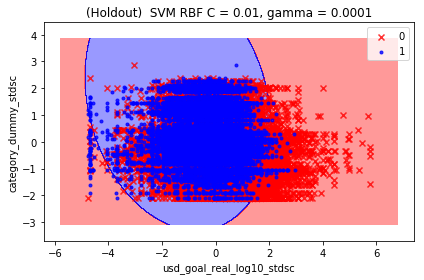

Holdout Log-likelihood = -21.523
Holdout Accuracy = 37.687%
kernel = rbf
C = 0.1
gamma = 1e-10



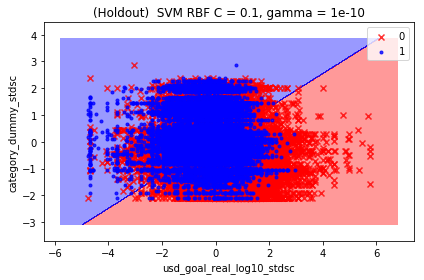

Holdout Log-likelihood = -12.231
Holdout Accuracy = 64.589%
kernel = rbf
C = 0.1
gamma = 1e-09



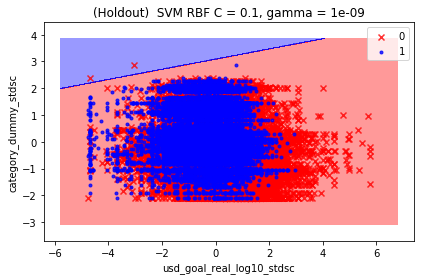

Holdout Log-likelihood = -12.222
Holdout Accuracy = 64.612%
kernel = rbf
C = 0.1
gamma = 1e-08



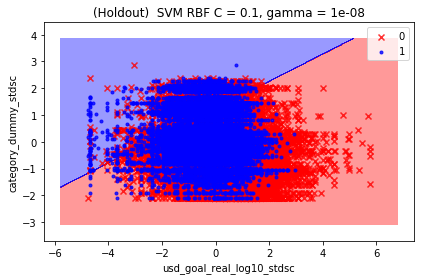

Holdout Log-likelihood = -10.964
Holdout Accuracy = 68.255%
kernel = rbf
C = 0.1
gamma = 1e-07



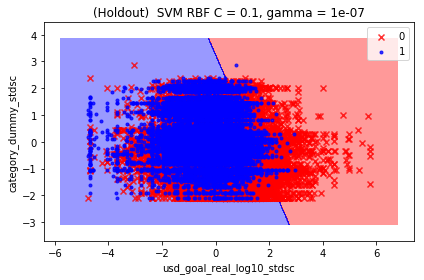

Holdout Log-likelihood = -20.807
Holdout Accuracy = 39.760%
kernel = rbf
C = 0.1
gamma = 1e-06



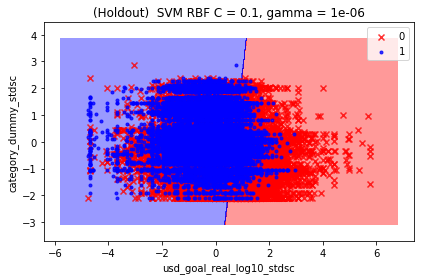

Holdout Log-likelihood = -17.127
Holdout Accuracy = 50.414%
kernel = rbf
C = 0.1
gamma = 1e-05



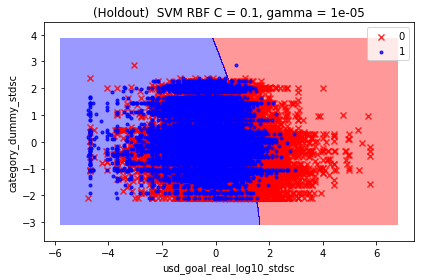

Holdout Log-likelihood = -19.75
Holdout Accuracy = 42.820%
kernel = rbf
C = 0.1
gamma = 0.0001



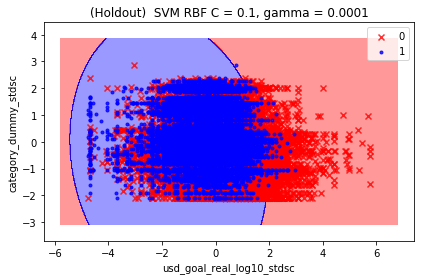

Holdout Log-likelihood = -21.419
Holdout Accuracy = 37.986%
kernel = rbf
C = 1.0
gamma = 1e-10



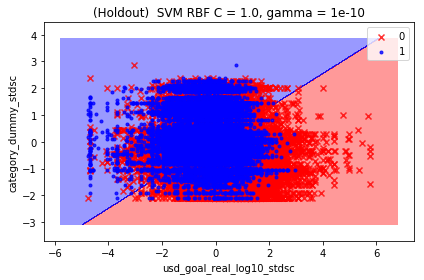

Holdout Log-likelihood = -12.231
Holdout Accuracy = 64.589%
kernel = rbf
C = 1.0
gamma = 1e-09



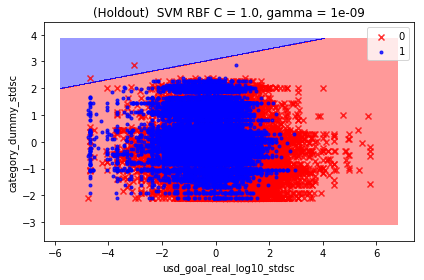

Holdout Log-likelihood = -12.222
Holdout Accuracy = 64.612%
kernel = rbf
C = 1.0
gamma = 1e-08



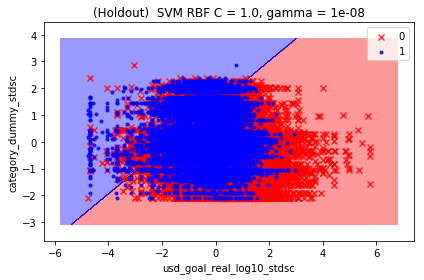

Holdout Log-likelihood = -10.894
Holdout Accuracy = 68.460%
kernel = rbf
C = 1.0
gamma = 1e-07



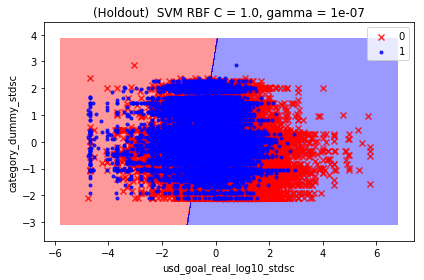

Holdout Log-likelihood = -22.402
Holdout Accuracy = 35.142%
kernel = rbf
C = 1.0
gamma = 1e-06



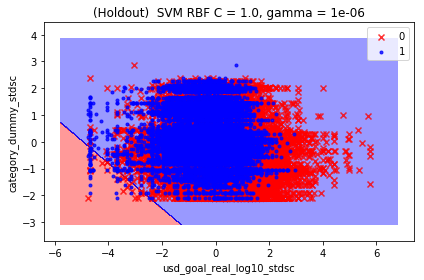

Holdout Log-likelihood = -22.331
Holdout Accuracy = 35.346%
kernel = rbf
C = 1.0
gamma = 1e-05



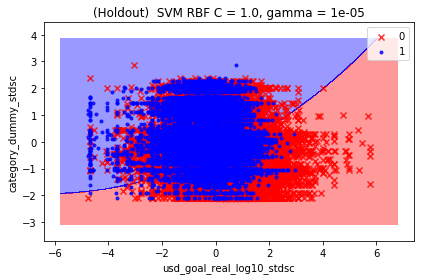

Holdout Log-likelihood = -14.574
Holdout Accuracy = 57.805%
kernel = rbf
C = 1.0
gamma = 0.0001



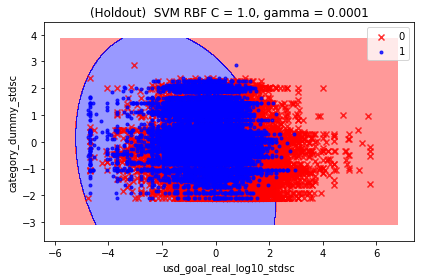

Holdout Log-likelihood = -21.618
Holdout Accuracy = 37.410%
kernel = rbf
C = 10.0
gamma = 1e-10



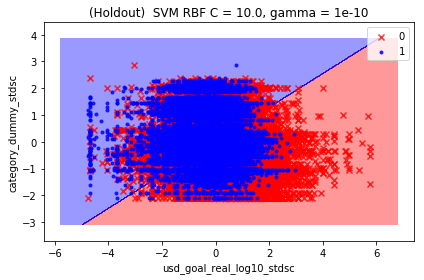

Holdout Log-likelihood = -12.231
Holdout Accuracy = 64.589%
kernel = rbf
C = 10.0
gamma = 1e-09



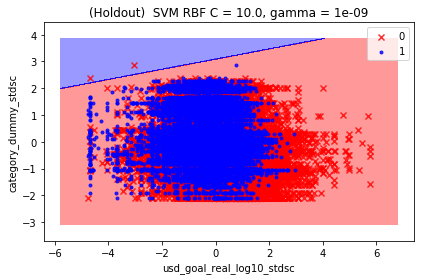

Holdout Log-likelihood = -12.222
Holdout Accuracy = 64.612%
kernel = rbf
C = 10.0
gamma = 1e-08



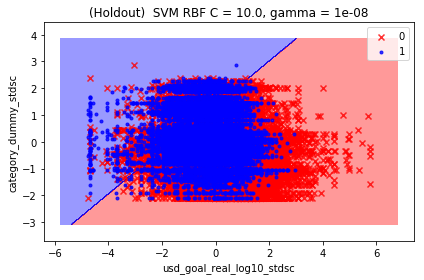

Holdout Log-likelihood = -10.894
Holdout Accuracy = 68.460%
kernel = rbf
C = 10.0
gamma = 1e-07



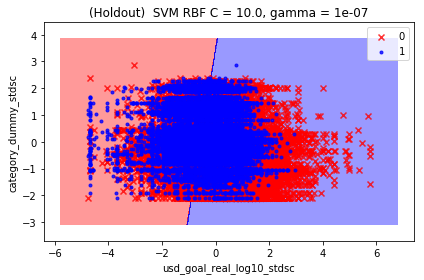

Holdout Log-likelihood = -22.402
Holdout Accuracy = 35.142%
kernel = rbf
C = 10.0
gamma = 1e-06



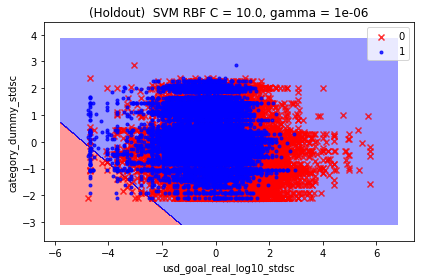

Holdout Log-likelihood = -22.331
Holdout Accuracy = 35.346%
kernel = rbf
C = 10.0
gamma = 1e-05



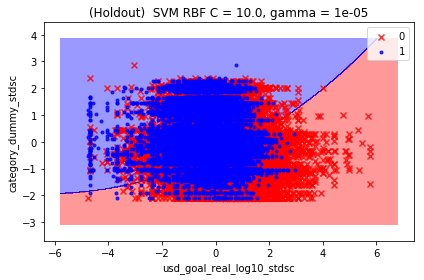

Holdout Log-likelihood = -14.574
Holdout Accuracy = 57.805%
kernel = rbf
C = 10.0
gamma = 0.0001



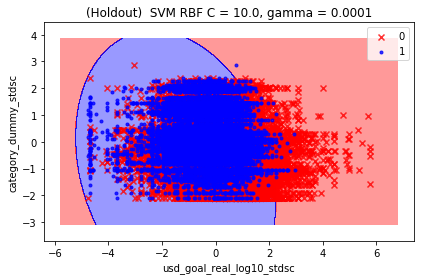

Holdout Log-likelihood = -21.618
Holdout Accuracy = 37.410%
kernel = rbf
C = 100.0
gamma = 1e-10



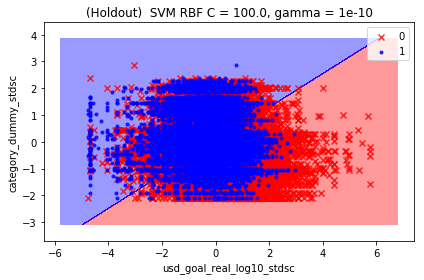

Holdout Log-likelihood = -12.231
Holdout Accuracy = 64.589%
kernel = rbf
C = 100.0
gamma = 1e-09



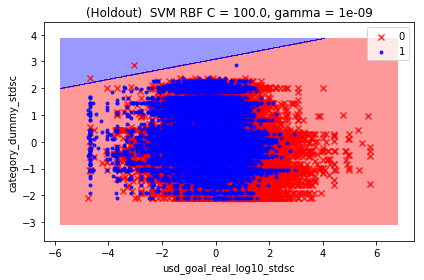

Holdout Log-likelihood = -12.222
Holdout Accuracy = 64.612%
kernel = rbf
C = 100.0
gamma = 1e-08



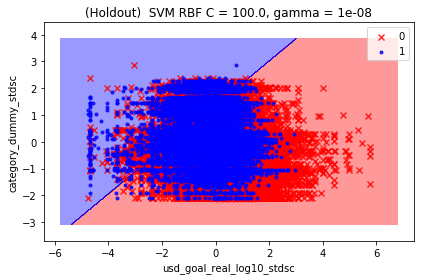

Holdout Log-likelihood = -10.894
Holdout Accuracy = 68.460%
kernel = rbf
C = 100.0
gamma = 1e-07



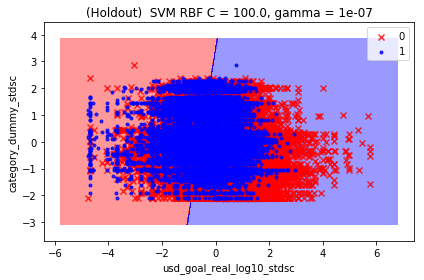

Holdout Log-likelihood = -22.402
Holdout Accuracy = 35.142%
kernel = rbf
C = 100.0
gamma = 1e-06



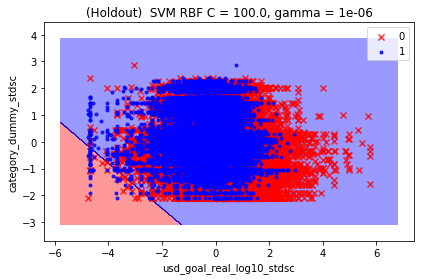

Holdout Log-likelihood = -22.331
Holdout Accuracy = 35.346%
kernel = rbf
C = 100.0
gamma = 1e-05



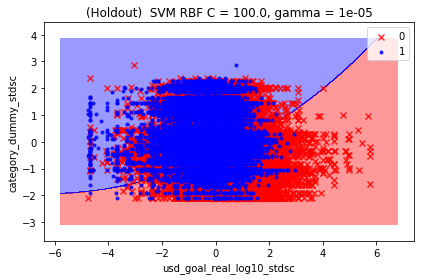

Holdout Log-likelihood = -14.574
Holdout Accuracy = 57.805%
kernel = rbf
C = 100.0
gamma = 0.0001



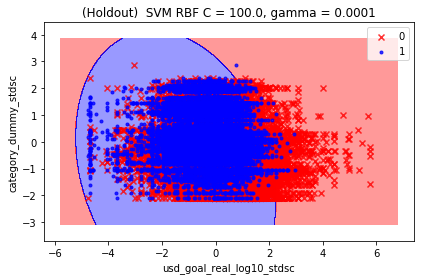

Holdout Log-likelihood = -21.618
Holdout Accuracy = 37.410%


In [30]:
kernel = 'rbf'
Cs = np.logspace(-4, 2, 7, base=10)
gammas = np.logspace(-10, -4, 7, base=10)

SVM_accuracy = []
SVM_log_likelihood = []
SVM_weight_abs_max = []
SVM_weight_abs_min = []


for C in Cs:
    for gamma in gammas:

        print('='*100)
        print('kernel =', kernel)
        print('C =', C)
        print('gamma =', gamma)
        print()

        y = df_TRAIN["state_dummy"].values
        X = df_TRAIN[["usd_goal_real_log10", "category"]].values

        # Holdout method
        test_size = 0.2        # 20%
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=1234) # Holdout


        df_X_train = pd.DataFrame(X_train,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_train = pd.DataFrame(y_train,
                                 columns=["state_dummy"])

        df_X_valid = pd.DataFrame(X_valid,
                                 columns=["usd_goal_real_log10", "category"])
        df_y_valid = pd.DataFrame(y_valid,
                                 columns=["state_dummy"])


        # Create dummy variables for category using train data
        # Replace category to category_success_rate
        category_success_rate = {}
        df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
        df_category_all_count = df_X_train['category'].value_counts()
        for category in df_category_all_count.keys():
            category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
        df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
        df_X_valid['category_dummy'] = df_X_valid['category'].replace(category_success_rate)

        X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
        X_valid = df_X_valid[["usd_goal_real_log10", "category_dummy"]].values

        # Normaliztion
        stdsc = StandardScaler()
        X_train = stdsc.fit_transform(X_train)
        X_valid = stdsc.transform(X_valid)

        clf = SVC(C=C,kernel=kernel, gamma=gamma, max_iter=2000, random_state=1234)
        clf.fit(X_train, y_train)

        # Predict labels
        y_est_valid = clf.predict(X_valid)

        # Log-likelihood
        holdout_log_likelihood = - log_loss(y_valid, y_est_valid)         

        # Accuracy
        holdout_accuracy = accuracy_score(y_valid, y_est_valid)

        plot_decision_regions(X_valid, y_valid, classifier=clf)
        plt.title('(Holdout)  SVM RBF C = %s, gamma = %s' %(C, gamma))
        plt.xlabel('usd_goal_real_log10_stdsc')
        plt.ylabel('category_dummy_stdsc')
        plt.axes().set_aspect('equal', 'datalim')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        # Generalization performance
        final_log_likelihood = holdout_log_likelihood
        print("Holdout Log-likelihood = %s"%round(final_log_likelihood, 3))
        final_accuracy = holdout_accuracy
        print('Holdout Accuracy = {:.3f}%'.format(100 * final_accuracy))

        SVM_accuracy.append(final_accuracy)
        SVM_log_likelihood.append(final_log_likelihood)

    

In [31]:
SVM_accuracy_2d = np.array(SVM_accuracy).reshape(7, 7)
Cs_str = list(map(str, Cs))
gammas_str = list(map(str, gammas))
df_SVM_accuracy_2d = pd.DataFrame(data=SVM_accuracy_2d, index=Cs_str, columns=gammas_str)
df_SVM_accuracy_2d

1e-10     1e-09     1e-08     1e-07     1e-06     1e-05    0.0001
0.0001  0.645892  0.646123  0.655151  0.617502  0.555293  0.377761  0.356270
0.001   0.645892  0.646123  0.670683  0.542089  0.538408  0.618163  0.351913
0.01    0.645892  0.646123  0.664559  0.567953  0.597960  0.612914  0.376869
0.1     0.645892  0.646123  0.682550  0.397600  0.504143  0.428201  0.379857
1.0     0.645892  0.646123  0.684597  0.351418  0.353464  0.578054  0.374096
10.0    0.645892  0.646123  0.684597  0.351418  0.353464  0.578054  0.374096
100.0   0.645892  0.646123  0.684597  0.351418  0.353464  0.578054  0.374096

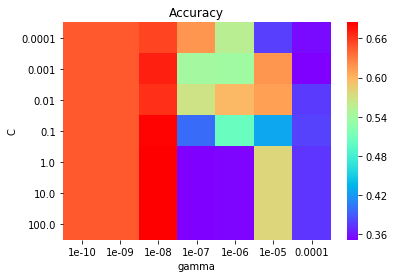

In [32]:
sns.heatmap(df_SVM_accuracy_2d, cmap='rainbow')
plt.ylabel("C")
plt.xlabel("gamma")
plt.title('Accuracy')
plt.show()

## Final Test

kernel = rbf
C = 100
gamma = 1e-08



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Test Log-likelihood = -13.727
Test Accuracy = 60.256%



/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


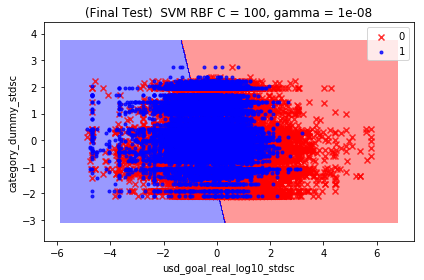

In [35]:
kernel = 'rbf'

# Best Parameter
C = 100
gamma = 1e-8


print('kernel =', kernel)
print('C =', C)
print('gamma =', gamma)
print()

# TRAIN data
df_y_train = df_TRAIN[["state_dummy"]]
df_X_train = df_TRAIN[["usd_goal_real_log10", "category"]]

# TEST data
df_y_test = df_TEST[["state_dummy"]]
df_X_test = df_TEST[["usd_goal_real_log10", "category"]]

# Create dummy variables for category using train data
# Replace category to category_success_rate
category_success_rate = {}
df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
df_category_all_count = df_X_train['category'].value_counts()
for category in df_category_all_count.keys():
    category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)



X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
X_test = df_X_test[["usd_goal_real_log10", "category_dummy"]].values

y_train = df_y_train[["state_dummy"]].values
y_test = df_y_test[["state_dummy"]].values

# print(X_test.shape)
# print(y_test.flatten().shape)

# print(X_valid.shape)
# print(y_valid.shape)

# Normaliztion
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

clf = SVC(C=C,kernel=kernel, gamma=gamma, max_iter=2000, random_state=1234)
clf.fit(X_train, y_train)

# Predict labels
y_est_test = clf.predict(X_test)

# Log-likelihood
log_likelihood = - log_loss(y_test, y_est_test)       
print('Test Log-likelihood = {:.3f}'.format(log_likelihood))

# Accuracy
accuracy = accuracy_score(y_test, y_est_test)  
print('Test Accuracy = {:.3f}%'.format(100 * accuracy))
print()

plot_decision_regions(X_test, y_test.flatten(), classifier=clf)
plt.title('(Final Test)  SVM RBF C = %s, gamma = %s' %(C, gamma))
plt.xlabel('usd_goal_real_log10_stdsc')
plt.ylabel('category_dummy_stdsc')
plt.axes().set_aspect('equal', 'datalim')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

    